# Imports

In [186]:
import sys
print(sys.executable)

/opt/miniconda3/envs/ml-lab-py311/bin/python


In [187]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", module="IPython")

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir)
    print("Local environment")

print(f"Root dir: {root_dir}")

# Add the root directory to the `PYTHONPATH`
if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added the following directory to the PYTHONPATH: {root_dir}")

# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Root dir: /Users/niklasdahlbom/Documents/GitHub/mlfs-book
HopsworksSettings initialized!


In [188]:
import datetime
import requests
import pandas as pd
import hopsworks
from mlfs.airquality import util
import datetime
from pathlib import Path
import json
import re
from xgboost import plot_importance
import warnings
import os
from dotenv import load_dotenv
warnings.filterwarnings("ignore")

### Model

In [189]:
from xgboost import XGBRegressor

# Path to your saved model
model_path = f"{root_dir}/notebooks/airquality/air_quality_model/model.json"

# Load the trained model
xgb_regressor = XGBRegressor()
xgb_regressor.load_model(model_path)

print("Model loaded successfully!")


Model loaded successfully!


### City data

In [190]:
# Load environment variables from .env
load_dotenv()

def get_aqicn_sensors():
    sensors = []
    i = 1
    while True:
        url = os.getenv(f"AQICN_URL{i}")
        country = os.getenv(f"AQICN_COUNTRY{i}")
        city = os.getenv(f"AQICN_CITY{i}")
        street = os.getenv(f"AQICN_STREET{i}")

        if not url:
            break  # Stop when there is no more AQICN_URL{i} in .env

        sensors.append({
            "url": url,
            "country": country,
            "city": city,
            "street": street
        })
        i += 1

    return sensors

# Example usage
sensors = get_aqicn_sensors()
for s in sensors:
    print(s)

{'url': 'https://api.waqi.info/feed/A71104', 'country': 'Sweden', 'city': 'Borgholm', 'street': 'Norra Långgatan'}
{'url': 'https://api.waqi.info/feed/A376954', 'country': 'Sweden', 'city': 'Ljugarn', 'street': 'Storvägen'}
{'url': 'https://api.waqi.info/feed/A60076', 'country': 'Sweden', 'city': 'Visby', 'street': 'Östra Tvärgatan'}


In [191]:
import pandas as pd

# Define your CSV files and sensor metadata
sensor_files = {
    "Kalmar": f"{root_dir}/data/kalmar-air-quality.csv",
    "VisbyLjugarn": f"{root_dir}/data/VisbyLjugarn-air-quality.csv",
    "VisbyOstraTvargatan": f"{root_dir}/data/VisbyOstraTvargatan-air-quality.csv"
}

sensor_metadata = {
    "Kalmar": {
        "country": "Sweden",
        "city": "Kalmar",
        "street": "Norra Långgatan",
        "latitude": 56.87982457051902,
        "longitude": 16.65778919093509
    },
    "VisbyLjugarn": {
        "country": "Sweden",
        "city": "Gotland",
        "street": "Storvägen, Ljugarn",
        "latitude": 57.3378981583593,
        "longitude": 18.700120215008033
    },
    "VisbyOstraTvargatan": {
        "country": "Sweden",
        "city": "Gotland",
        "street": "Östra Tvärgatan, Visby",
        "latitude": 57.6339483,
        "longitude": 18.31051
    }
}

In [192]:
def load_and_process_sensor(csv_file, metadata):
    util.check_file_path(csv_file)  # Ensure file exists
    df = pd.read_csv(csv_file, parse_dates=['date'], skipinitialspace=True)

    # Rename PM2.5 column
    if 'median' in df.columns:
        df.rename(columns={'median': 'pm25'}, inplace=True)

    # Sort and create lag features
    df = df.sort_values('date').reset_index(drop=True)
    for lag in range(1, 4):
        df[f'pm25_lag_{lag}'] = df['pm25'].shift(lag)
    df.fillna(0, inplace=True)

    # Add sensor metadata
    df['country'] = metadata['country']
    df['city'] = metadata['city']
    df['street'] = metadata['street']

    return df


In [193]:
# Process all sensors
sensor_dfs = {}
for name, csv_file in sensor_files.items():
    sensor_dfs[name] = load_and_process_sensor(csv_file, sensor_metadata[name])

# Optional: Combine all sensors into one DataFrame
df_features = pd.concat(sensor_dfs.values(), ignore_index=True)
df_features = df_features.sort_values('date').reset_index(drop=True)

df_features.head()

File successfully found at the path: /Users/niklasdahlbom/Documents/GitHub/mlfs-book/data/kalmar-air-quality.csv
File successfully found at the path: /Users/niklasdahlbom/Documents/GitHub/mlfs-book/data/VisbyLjugarn-air-quality.csv
File successfully found at the path: /Users/niklasdahlbom/Documents/GitHub/mlfs-book/data/VisbyOstraTvargatan-air-quality.csv


,date,min,max,pm25,q1,q3,stdev,count,pm25_lag_1,pm25_lag_2,pm25_lag_3,country,city,street
0,2019-12-09 00:00:00+00:00,1.60,3.16,2.29,2.12,2.54,0.317,310,0.00,0.00,0.0,Sweden,Kalmar,Norra Långgatan
1,2019-12-09 00:00:00+00:00,1.76,5.24,2.41,2.15,2.82,0.517,315,0.00,0.00,0.0,Sweden,Gotland,"Östra Tvärgatan, Visby"
2,2019-12-10 00:00:00+00:00,0.40,17.10,1.38,0.97,2.16,2.209,387,2.41,0.00,0.0,Sweden,Gotland,"Östra Tvärgatan, Visby"
3,2019-12-10 00:00:00+00:00,0.57,5.85,1.10,0.85,1.86,0.811,387,2.29,0.00,0.0,Sweden,Kalmar,Norra Långgatan
4,2019-12-11 00:00:00+00:00,1.30,7.00,2.86,2.50,3.34,0.887,423,1.10,2.29,0.0,Sweden,Kalmar,Norra Långgatan


### Weather data

In [194]:
def prepare_station_features(station_name, weather_df, pm25_init=[0,0,0], street_name=""):
    """
    Build a feature DataFrame for a single station.

    Parameters:
    - station_name: str, name of the station
    - weather_df: pd.DataFrame with columns ['date', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
    - pm25_init: list of 3 floats, initial PM2.5 lag values [lag_1, lag_2, lag_3]

    Returns:
    - df_pred: pd.DataFrame ready for prediction
    """
    df_pred = weather_df.copy()

    # Ensure datetime type and remove timezone if present
    df_pred['date'] = pd.to_datetime(df_pred['date']).dt.tz_localize(None)

    # Add lag features
    df_pred['pm25_lag_1'] = pm25_init[0]
    df_pred['pm25_lag_2'] = pm25_init[1]
    df_pred['pm25_lag_3'] = pm25_init[2]

    # Add station identifier
    df_pred['city'] = station_name
    df_pred['street'] = street_name

    return df_pred

In [195]:
def predict_pm25(df_pred, model):
    """
    Fill 'pm25_predicted' column using rolling lag features.

    Parameters:
    - df_pred: pd.DataFrame with feature columns and initial lag values
    - model: trained XGBoost or sklearn regressor

    Returns:
    - df_pred with 'pm25_predicted' column filled
    """
    df_pred = df_pred.copy()
    df_pred['pm25_predicted'] = 0.0

    for i in range(len(df_pred)):
        # Prepare features for prediction
        X = df_pred.loc[i, ['temperature_2m_mean', 'precipitation_sum',
                            'wind_speed_10m_max', 'wind_direction_10m_dominant',
                            'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3']].values.reshape(1, -1)

        # Predict
        pred = model.predict(X)[0]
        df_pred.loc[i, 'pm25_predicted'] = pred

        # Update lag features for next row
        if i + 1 < len(df_pred):
            df_pred.loc[i+1, 'pm25_lag_1'] = pred
        if i + 2 < len(df_pred):
            df_pred.loc[i+2, 'pm25_lag_2'] = pred
        if i + 3 < len(df_pred):
            df_pred.loc[i+3, 'pm25_lag_3'] = pred

    return df_pred

In [196]:
def predict_multiple_stations(stations, weather_dict, model):
    """
    Run PM2.5 prediction for multiple stations.

    Parameters:
    - stations: list of dicts with keys ['name', 'init_lags']
    - weather_dict: dict mapping station_name -> weather_df
    - model: trained XGBoost model

    Returns:
    - combined pd.DataFrame for all stations
    """
    all_predictions = []
    for s in stations:
        df_pred = prepare_station_features(s['name'], weather_dict[s['name']], s['init_lags'], s['street'])
        df_pred = predict_pm25(df_pred, model)
        all_predictions.append(df_pred)

    final_df = pd.concat(all_predictions, ignore_index=True)
    return final_df

In [197]:
from datetime import date

today = date.today()

# Add coordinates and start/end dates to metadata
for name, df in sensor_dfs.items():
    earliest_aq_date = df['date'].min().strftime('%Y-%m-%d')
    sensor_metadata[name]['latitude'] = sensor_metadata[name].get('latitude')  # or hardcode if needed
    sensor_metadata[name]['longitude'] = sensor_metadata[name].get('longitude')
    sensor_metadata[name]['start_date'] = earliest_aq_date
    sensor_metadata[name]['end_date'] = today.strftime('%Y-%m-%d')

# Fetch weather data for all sensors
weather_dict = {}
for name, meta in sensor_metadata.items():
    print(f"Fetching weather for {name}...")
    weather_df = util.get_historical_weather(
        city=meta['city'],
        start_date=meta['start_date'],
        end_date=meta['end_date'],
        latitude=meta['latitude'],
        longitude=meta['longitude']
    )
    weather_dict[name] = weather_df

# Prepare stations for prediction
stations = [
    {"name": name, "init_lags": [0,0,0], "street": meta["street"]}
    for name, meta in sensor_metadata.items()
]
# Run predictions
all_predictions = predict_multiple_stations(stations, weather_dict, xgb_regressor)
all_predictions.rename(columns={'pm25_predicted': 'predicted_pm25'}, inplace=True)
for name in sensor_dfs:
    df_actual = sensor_dfs[name][['date', 'pm25']].copy()
    df_actual['date'] = pd.to_datetime(df_actual['date']).dt.tz_localize(None)
    mask = all_predictions['city'] == name
    all_predictions.loc[mask, 'pm25'] = all_predictions.loc[mask, 'date'].map(
        df_actual.set_index('date')['pm25']
    )
print(all_predictions.head())


Fetching weather for Kalmar...
Coordinates 56.90685272216797°N 16.8631591796875°E
Elevation 5.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Fetching weather for VisbyLjugarn...
Coordinates 57.328643798828125°N 18.614072799682617°E
Elevation 11.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Fetching weather for VisbyOstraTvargatan...
Coordinates 57.609840393066406°N 18.387096405029297°E
Elevation 48.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
        date  temperature_2m_mean  precipitation_sum  wind_speed_10m_max  \
0 2019-12-09             5.729416           0.700000           28.954834   
1 2019-12-10             1.156500           1.700000           39.909698   
2 2019-12-11             4.683583           6.199999           35.870163   
3 2019-12-12             3.398167           2.100000           22.725668   
4 2019-12-13             4.425250           6.200000           27.295977   

   wind_direction_10m_dominant    city  pm25_lag_1  pm

📊 Plotting predicted vs actual PM2.5 for each station...



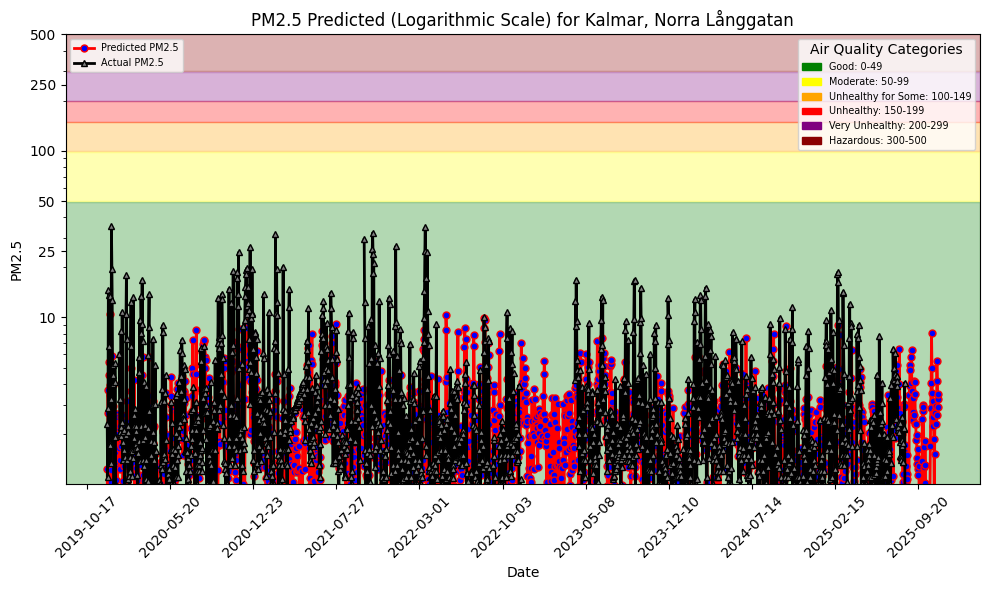

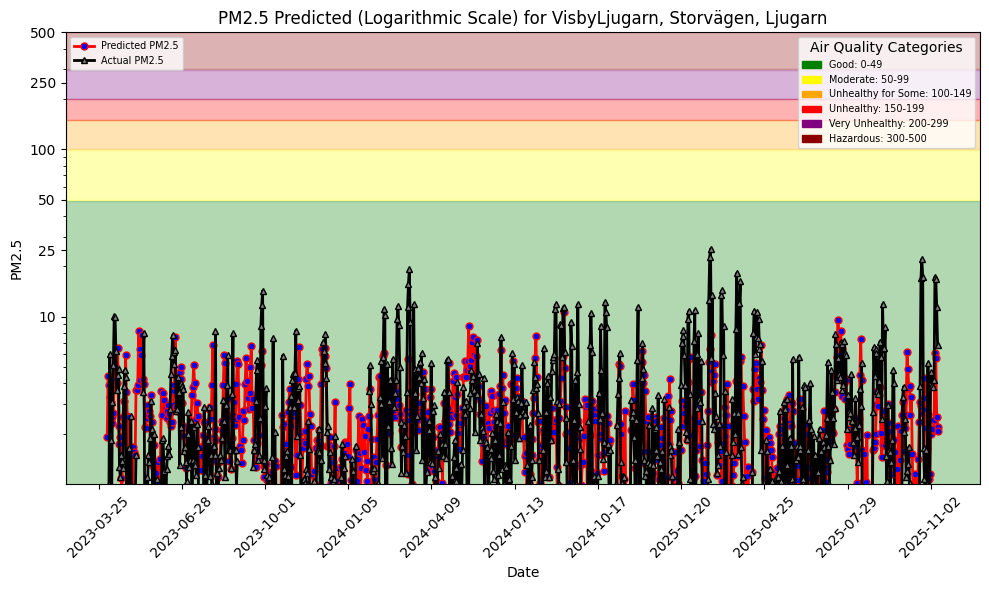

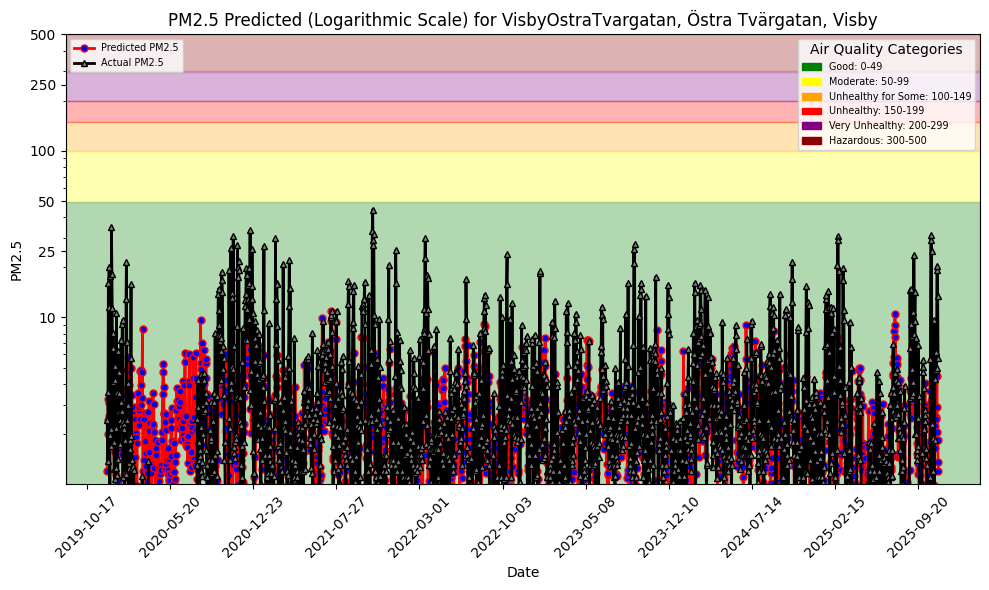


📈 Plotting XGBoost feature importances...



<Figure size 1000x600 with 0 Axes>

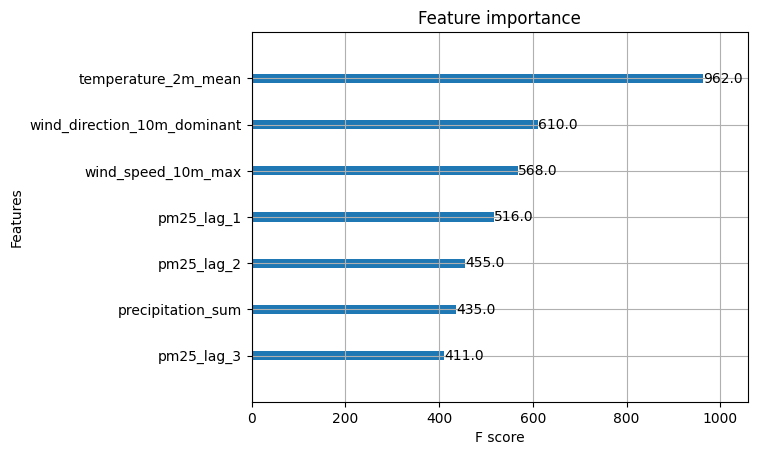


📝 Summary statistics for actual vs predicted PM2.5:

| Station             |   Actual Mean PM2.5 |   Actual Variance PM2.5 |   Predicted Mean PM2.5 |   Predicted Variance PM2.5 |
|:--------------------|--------------------:|------------------------:|-----------------------:|---------------------------:|
| Kalmar              |                3.14 |                   13.79 |                   2.27 |                       2.09 |
| VisbyLjugarn        |                2.76 |                    9.9  |                   2.43 |                       2.25 |
| VisbyOstraTvargatan |                3.51 |                   21.23 |                   2.38 |                       2.24 |


In [204]:
# --- Directory for saving plots ---
images_dir = os.path.join(root_dir, "notebooks/airquality/A_images")
os.makedirs(images_dir, exist_ok=True)

# --- 1️⃣ Plot predicted vs actual PM2.5 for each station ---
print("📊 Plotting predicted vs actual PM2.5 for each station...\n")
for city_name in all_predictions['city'].unique():
    df_city = all_predictions[all_predictions['city'] == city_name]
    street_name = df_city['street'].iloc[0]  # pick the street from metadata
    file_path = os.path.join(images_dir, f"{city_name}_forecast.png")

    plt_obj = util.plot_air_quality_forecast(city_name, street_name, df_city, file_path, hindcast=True)
    plt_obj.show()

# --- 2️⃣ Plot feature importances from XGBoost ---
print("\n📈 Plotting XGBoost feature importances...\n")
plt.figure(figsize=(10,6))
plot_importance(xgb_regressor)
feature_importance_path = os.path.join(images_dir, "feature_importance.png")
plt.savefig(feature_importance_path)
plt.show()

# --- 3️⃣ Create summary table of actual vs predicted PM2.5 ---
print("\n📝 Summary statistics for actual vs predicted PM2.5:\n")
summary_stats = []

for name in sensor_dfs:
    df_actual = sensor_dfs[name][['pm25']].copy()
    df_pred = all_predictions[all_predictions['city'] == name]['predicted_pm25']

    summary_stats.append({
        "Station": name,
        "Actual Mean PM2.5": round(df_actual['pm25'].mean(), 2),
        "Actual Variance PM2.5": round(df_actual['pm25'].var(), 2),
        "Predicted Mean PM2.5": round(df_pred.mean(), 2),
        "Predicted Variance PM2.5": round(df_pred.var(), 2)
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_markdown(index=False))
